In [4]:
from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
data = pd.read_csv("MicrosoftStock.csv")
print(data.head())
print(data.info())
print(data.describe())

    index        date   open   high    low  close    volume  Name
0  390198  2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199  2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200  2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201  2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202  2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB
None
               index         open         high          low 

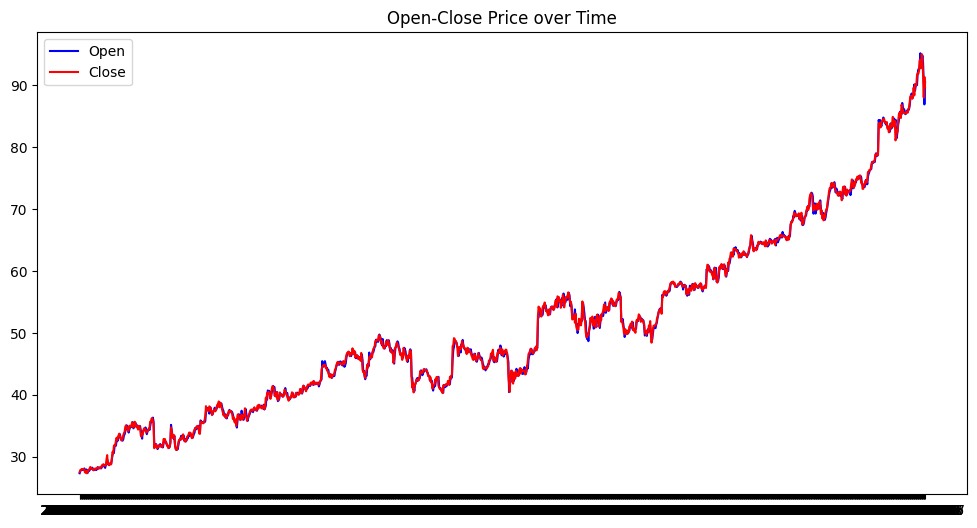

In [6]:
# Initial Data Visualization
# Plot 1 - Open and Close Prices of time
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['open'], label="Open",color="blue")
plt.plot(data['date'], data['close'], label="Close",color="red")
plt.title("Open-Close Price over Time")
plt.legend()

Text(0.5, 1.0, 'Stock Volume over Time')

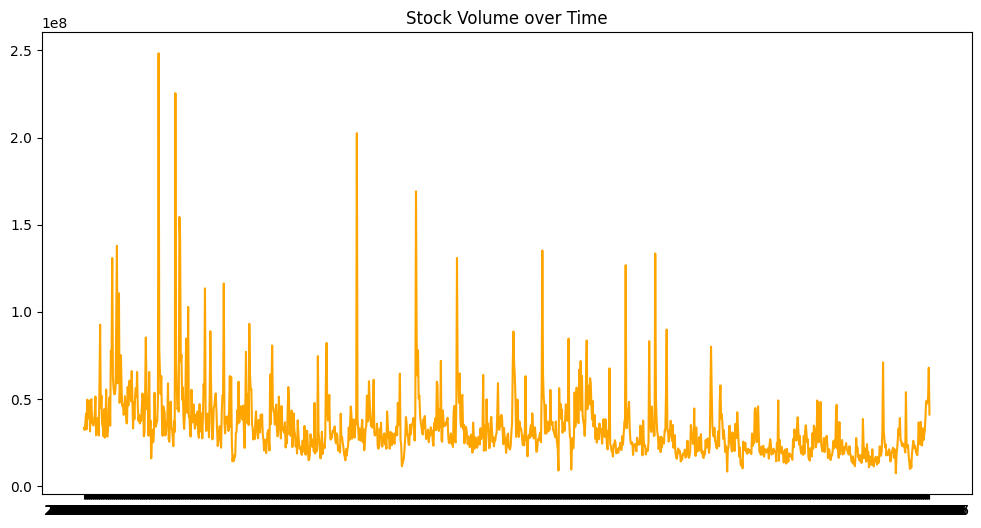

In [7]:
# Plot 2 - Trading Volume (check for outliers)
plt.figure(figsize=(12,6))
plt.plot(data['date'],data['volume'],label="Volume",color="orange")
plt.title("Stock Volume over Time")
# plt.show()


In [8]:
# Drop non-numeric columns
numeric_data = data.select_dtypes(include=["int64","float64"])

Text(0.5, 1.0, 'Feature Correlation Heatmap')

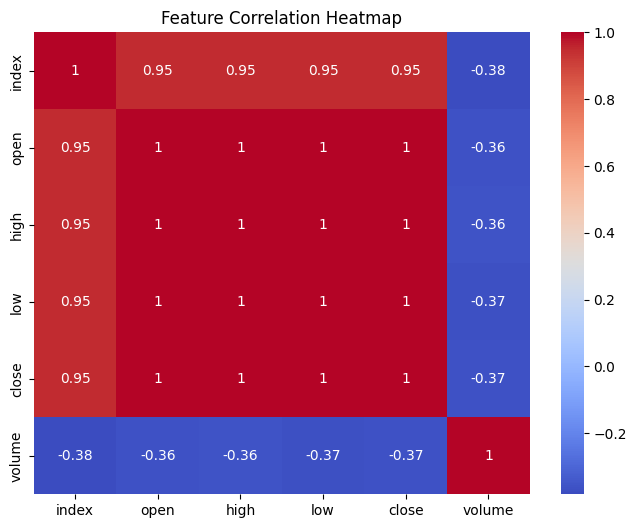

In [9]:
# Plot 3 - Check for correlation between features
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")


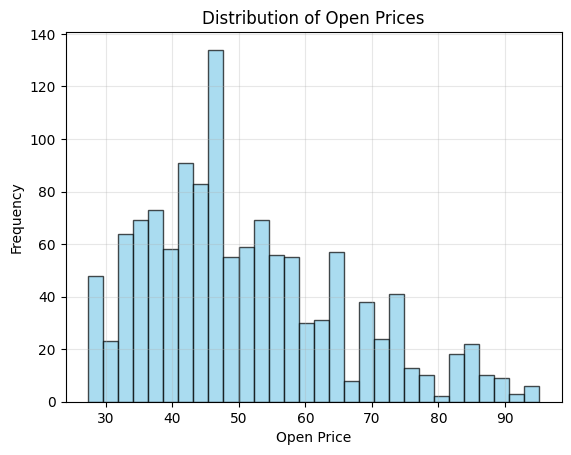

In [10]:
# Plot 4 - Distribution of Open Prices
plt.hist(data['open'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Distribution of Open Prices")
plt.xlabel("Open Price")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
# Convert the Data into Date time then create a date filter
data['date'] = pd.to_datetime(data['date'])

In [12]:
prediction = data.loc[
    (data['date'] > datetime(2013,1,1)) &
    (data['date'] < datetime(2018,1,1))
]

Text(0.5, 1.0, 'Price over time')

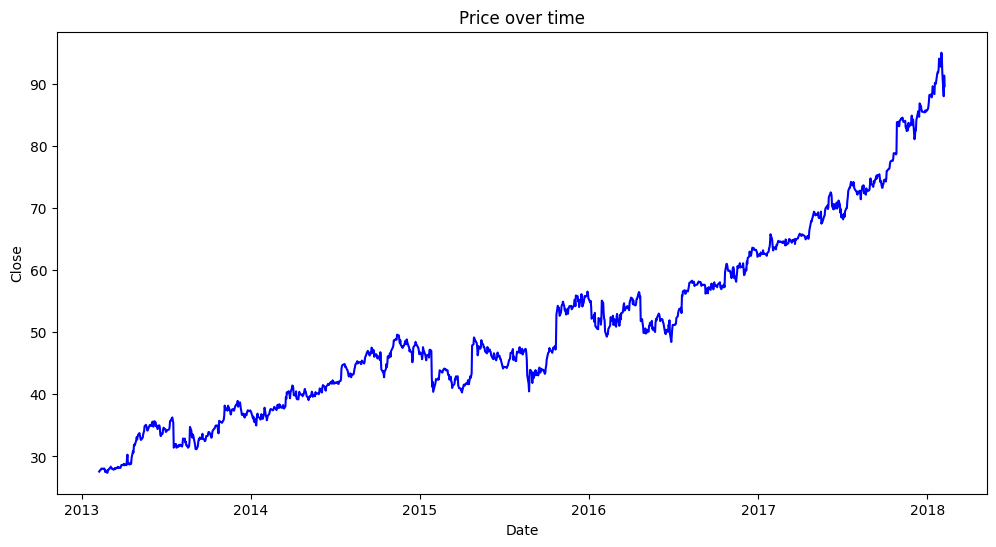

In [13]:
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['close'],color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")


In [14]:
# Prepare for the LSTM Model (Sequential)
stock_close = data.filter(["close"])
dataset = stock_close.values #convert to numpy array
training_data_len = int(np.ceil(len(dataset) * 0.95))

In [15]:
# Preprocessing Stages
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)
training_data = scaled_data[:training_data_len] #95% of all out data
X_train, y_train = [], []

In [16]:
# Create a sliding window for our stock (60 days)
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i,0])

In [17]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
# Build the Model
model = keras.models.Sequential()
# First Layer
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
# Second Layer
model.add(keras.layers.LSTM(64, return_sequences=False))

# 3rd Layer (Dense)
model.add(keras.layers.Dense(128, activation="relu"))

# 4th Layer (Dropout)
model.add(keras.layers.Dropout(0.5))

# Final Output Layer
model.add(keras.layers.Dense(1))


In [20]:
model.summary()
model.compile(optimizer="adam",
              loss="mae",
              metrics=[keras.metrics.RootMeanSquaredError()])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 58369 (228.00 KB)
Trainable params: 58369 (228.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
training = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
36/36 [==============================] - 4s 28ms/step - loss: 0.2750 - root_mean_squared_error: 0.4196
Epoch 2/20
36/36 [==============================] - 1s 27ms/step - loss: 0.1284 - root_mean_squared_error: 0.1721
Epoch 3/20
36/36 [==============================] - 1s 25ms/step - loss: 0.1126 - root_mean_squared_error: 0.1547
Epoch 4/20
36/36 [==============================] - 1s 27ms/step - loss: 0.1146 - root_mean_squared_error: 0.1588
Epoch 5/20
36/36 [==============================] - 1s 29ms/step - loss: 0.1180 - root_mean_squared_error: 0.1610
Epoch 6/20
36/36 [==============================] - 1s 27ms/step - loss: 0.1070 - root_mean_squared_error: 0.1484
Epoch 7/20
36/36 [==============================] - 1s 25ms/step - loss: 0.1108 - root_mean_squared_error: 0.1510
Epoch 8/20
36/36 [==============================] - 1s 25ms/step - loss: 0.1060 - root_mean_squared_error: 0.1390
Epoch 9/20
36/36 [==============================] - 1s 24ms/step - loss: 0.1091 - root_m

In [22]:
# Prep the test data
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]


In [23]:
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))


In [24]:
# Make a Prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


2/2 [==============================] - 1s 14ms/step


In [25]:
# Plotting data
train = data[:training_data_len]
test =  data[training_data_len:]
test = test.copy()
test['Predictions'] = predictions

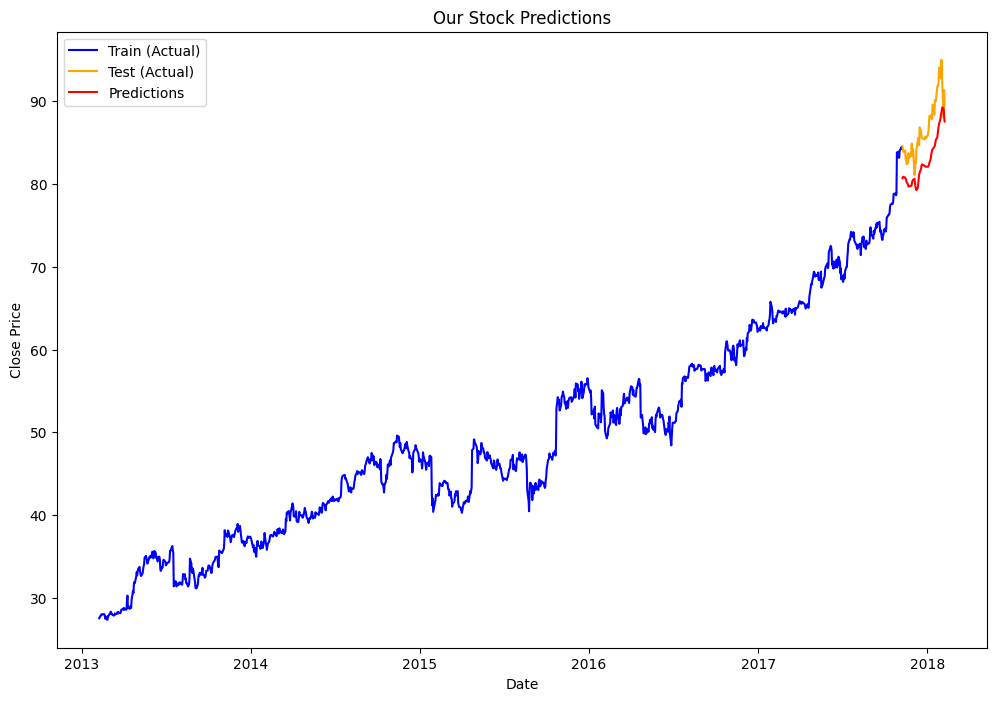

In [26]:
plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()